In [1]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 532 (delta 396), reused 458 (delta 322), pack-reused 0
Receiving objects: 100% (532/532), 3.49 MiB | 2.25 MiB/s, done.
Resolving deltas: 100% (396/396), done.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
from Eunomia.degree import *
from Eunomia.experiments import *
import networkx as nx
import numpy as np

pyro.set_rng_seed(1)

In [6]:

#suffrages = np.random.randint(0,100,(N_CHAMBERS, N_PARTYS)).astype(float)

suffrages = np.array([
        np.array([100, 25, 15]),
        np.array([100, 15, 25]),
])

N_CHAMBERS = 2
N_PARTYS = suffrages.shape[1]

def evaluate_coalition(coalition, effectifs):
    return np.where(effectifs[:, coalition].sum(axis = 1) > 0.5)[0].shape[0]

def compute_data(n_partis, evaluation_function, effectifs):
    alternatives = [sparse_to_alt(tuple(i), n_partis) for i in generate_additive_theta(n_partis,n_partis - 1)]
    theta = [tuple(i) for i in generate_additive_theta(n_partis,n_partis-1)]
    ranks = []
    for a in alternatives:
        ranks.append(evaluation_function(alt_to_sparse(a), effectifs))
    alternatives = np.array(alternatives)
    ranks = np.array(ranks)
    preferences = PreferenceModel(alternatives, ranks)
    data = preferences.generate_preference_matrix(theta)
    data = torch.tensor(data).float()
    return data ,theta

def plot_gaussians(means, stds, labels = None):
    if not labels:
        labels = [str(i) for i in range(means.shape[0])]
    # Create a range of x values
    x = np.linspace(min(means) - 3*max(stds), max(means) + 3*max(stds), 1000)

    # Plot each Gaussian
    for mean, std, label in zip(means, stds, labels):
        y = norm.pdf(x, mean, std)
        plt.plot(x, y, label=label)

    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()
    


def linear_scaling(x):
    return x / x.sum()

def pol_scaling(x , degree = 3):
    y = np.power(x, degree)
    return y / y.sum()


def scale(suffrages, scaling_functions):
    nsf = []
    for i in range(suffrages.shape[0]):
        nsf.append(scaling_functions[i](suffrages[i, :]))
    return np.array(nsf)


In [16]:


def create_data(n_partis, evaluation_function, k = 2):
    alternatives = [sparse_to_alt(tuple(i), n_partis) for i in generate_additive_theta(n_partis,n_partis - 1)]
    theta = [tuple(i) for i in generate_additive_theta(n_partis,k)]
    ranks = []
    for a in alternatives:
        ranks.append(evaluation_function(alt_to_sparse(a)))
    alternatives = np.array(alternatives)
    ranks = np.array(ranks)
    preferences = PreferenceModel(alternatives, ranks)
    data = preferences.generate_preference_matrix(theta)
    data = torch.tensor(data).float()
    return data ,theta

def coalition_effectifs(coalition, effectifs, affinities):
    edges, weights = maximum_spanning_tree_subset(affinities, coalition)
    p = np.prod(weights)
    L = []
    for chamber_id in range(effectifs.shape[0]):
        L.append(effectifs[chamber_id, coalition].sum()*p)
    return np.array(L)


def coalition_evaluation(c_effectifs, quotas = None):
    if not quotas:
        quotas = np.array([0.5]*c_effectifs.shape[0])
    c = np.where(c_effectifs > quotas)
    if c_effectifs[0] > 0.5 and c_effectifs[1] > 0.5:
        return 3
    elif c_effectifs[0] > 0.5:
        return 2
    elif c_effectifs[1] > 0.5:
        return 1
    return 0


def maximum_spanning_tree_subset(adj_matrix, vertices):
    # Number of vertices
    n = len(adj_matrix)

    # Create an empty graph
    G = nx.Graph()

    # Add nodes and edges to the graph
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i, j, weight=-adj_matrix[i][j])  # Negate weight for maximum spanning tree

    # Create a subgraph with only the specified vertices
    subgraph = G.subgraph(vertices)

    # Compute the maximum spanning tree (inverted minimum spanning tree)
    mst = nx.minimum_spanning_tree(subgraph, algorithm='kruskal')

    # Negate the weights back and collect edges and weights
    edges = []
    weights = []
    for (u, v, wt) in mst.edges.data('weight'):
        edges.append((u, v))
        weights.append(-wt)

    return edges, weights



In [27]:
suffrages = np.array([
        np.array([40, 20, 20, 20]),
        np.array([40, 20, 20, 20]),
])


effectifs = scale(suffrages, [linear_scaling, linear_scaling, linear_scaling])

adj_matrix = np.ones((5,5))

adj_matrix

data, theta = create_data(effectifs.shape[1], lambda c:coalition_evaluation(coalition_effectifs(c, effectifs, adj_matrix), quotas = [0.5, 0.5]))

In [28]:
sigma_w = 1e-1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [02:20, 17.73it/s, step size=1.83e-01, acc. prob=0.720]


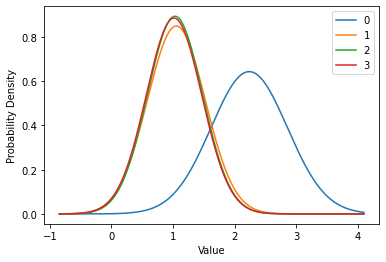

In [30]:
svs = np.array([compute_semivalues(effectifs.shape[1], theta, weights, lambda x:1)for weights in sampled_weights])
means, stds = svs.mean(axis = 0), svs.std(axis = 0)
plot_gaussians(means, stds)

In [31]:
suffrages = np.array([
        np.array([30,15,15,15,15,10]),
        np.array([30,15,15,15,15,10]),
])


effectifs = scale(suffrages, [linear_scaling, linear_scaling, linear_scaling])


adj_matrix = np.ones((5,5))

data, theta = create_data(effectifs.shape[1], lambda c:coalition_evaluation(coalition_effectifs(c, effectifs, adj_matrix), quotas = [0.5, 0.5]))

In [32]:
sigma_w = 1e-1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [05:18,  7.86it/s, step size=5.98e-02, acc. prob=0.792]


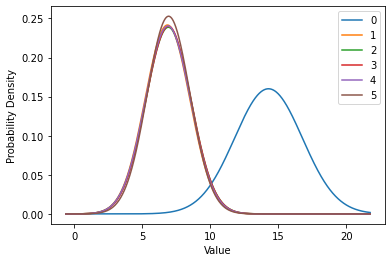

In [33]:
svs = np.array([compute_semivalues(effectifs.shape[1], theta, weights, lambda x:1)for weights in sampled_weights])
means, stds = svs.mean(axis = 0), svs.std(axis = 0)
plot_gaussians(means, stds)

In [39]:
suffrages = np.array([
        np.array([20,10,10,10,10,10,10,10,10]),
        np.array([20,10,10,10,10,10,10,10,10]),
])


effectifs = scale(suffrages, [linear_scaling, linear_scaling])


adj_matrix = np.ones((5,5))

data, theta = create_data(effectifs.shape[1], lambda c:coalition_evaluation(coalition_effectifs(c, effectifs, adj_matrix), quotas = [0.5, 0.5]))

In [41]:
sigma_w = 1
sigma_p = 1
n_samples = 1000

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=500, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 1500/1500 [21:07,  1.18it/s, step size=1.56e-02, acc. prob=0.874]


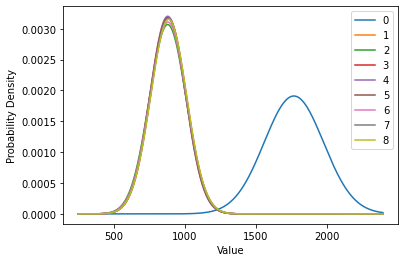

In [42]:
svs = np.array([compute_semivalues(effectifs.shape[1], theta, weights, lambda x:1)for weights in sampled_weights])
means, stds = svs.mean(axis = 0), svs.std(axis = 0)
plot_gaussians(means, stds)

In [70]:
suffrages = np.array([
        np.array([2, 1, 1, 1]),
        np.array([2, 1, 1, 1]),
])


effectifs = scale(suffrages, [linear_scaling, linear_scaling, linear_scaling])

adj_matrix = np.ones((5,5))

adj_matrix

data, theta = create_data(effectifs.shape[1], lambda c:coalition_evaluation(coalition_effectifs(c, effectifs, adj_matrix), quotas = [0.5, 0.5]))

In [71]:
sigma_w = 1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=500, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2000/2000 [02:28, 13.45it/s, step size=1.40e-01, acc. prob=0.790]


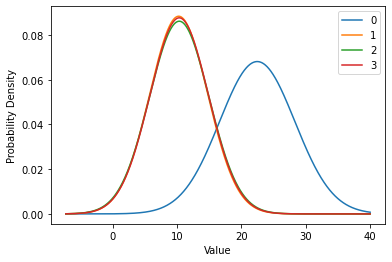

In [73]:
svs_1 = np.array([compute_semivalues(effectifs.shape[1], theta, weights, lambda x:1)for weights in sampled_weights])
means_1, stds_1 = svs_1.mean(axis = 0), svs_1.std(axis = 0)
plot_gaussians(means_1, stds_1)

In [51]:
suffrages = np.array([
        np.array([2, 1, 1, 1, 1, 1]),
        np.array([2, 1, 1, 1, 1, 1]),
])


effectifs = scale(suffrages, [linear_scaling, linear_scaling, linear_scaling])

adj_matrix = np.ones((5,5))

adj_matrix

data, theta = create_data(effectifs.shape[1], lambda c:coalition_evaluation(coalition_effectifs(c, effectifs, adj_matrix), quotas = [0.5, 0.5]))

In [52]:
sigma_w = 1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=500, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2000/2000 [03:37,  9.18it/s, step size=6.55e-02, acc. prob=0.736]


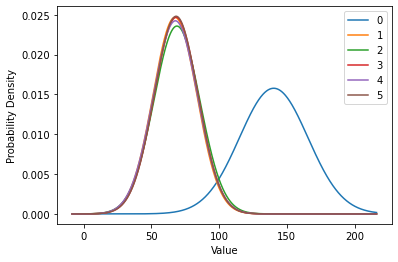

In [54]:
svs_2 = np.array([compute_semivalues(effectifs.shape[1], theta, weights, lambda x:1)for weights in sampled_weights])
means_2, stds_2 = svs_2.mean(axis = 0), svs_2.std(axis = 0)
plot_gaussians(means_2, stds_2)

In [55]:
suffrages = np.array([
        np.array([2, 1, 1, 1, 1, 1, 1, 1]),
        np.array([2, 1, 1, 1, 1, 1, 1, 1]),
])


effectifs = scale(suffrages, [linear_scaling, linear_scaling, linear_scaling])

adj_matrix = np.ones((effectifs.shape[1],effectifs.shape[1]))

adj_matrix

data, theta = create_data(effectifs.shape[1], lambda c:coalition_evaluation(coalition_effectifs(c, effectifs, adj_matrix), quotas = [0.5, 0.5]))

In [56]:
sigma_w = 1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=500, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2000/2000 [07:03,  4.72it/s, step size=3.83e-02, acc. prob=0.705]


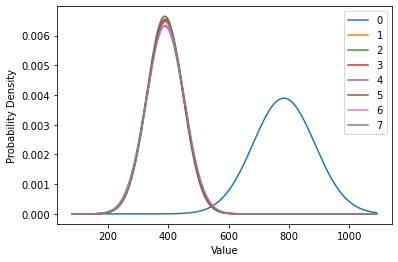

In [57]:
svs_3 = np.array([compute_semivalues(effectifs.shape[1], theta, weights, lambda x:1)for weights in sampled_weights])
means_3, stds_3 = svs_3.mean(axis = 0), svs_3.std(axis = 0)
plot_gaussians(means_3, stds_3)

In [79]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_normals(tuple1, tuple2, tuple3):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 subplots

    # Function to plot normals on a given axis
    def plot_normal(ax, mean_vector, std_vector, title):
        x = np.linspace(min(mean_vector) - 3*max(std_vector), max(mean_vector) + 3*max(std_vector), 100)
        for mean, std in zip(mean_vector, std_vector):
            y = norm.pdf(x, mean, std)
            ax.plot(x, y)
        ax.set_title(title)

    # Plot each tuple on its respective axis
    plot_normal(axes[0], *tuple1, "Case 1")
    plot_normal(axes[1], *tuple2, "Case 2")
    plot_normal(axes[2], *tuple3, "Case 3")

    plt.tight_layout()
    plt.savefig("Handmade_comparison.PNG")
    plt.show()

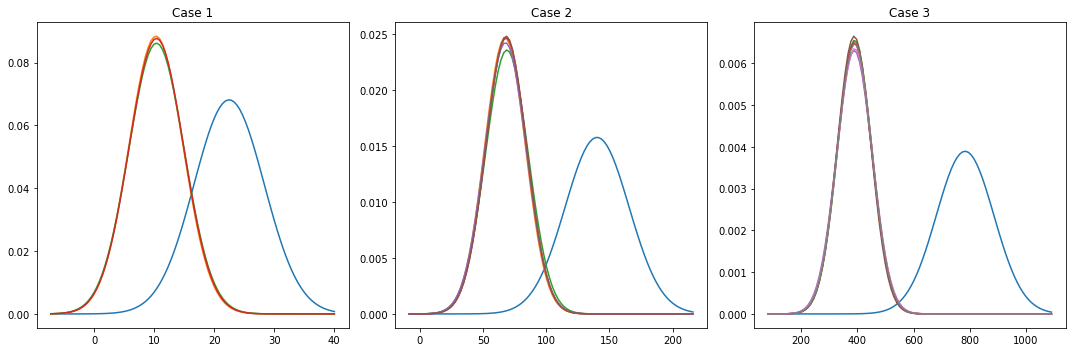

In [80]:
plot_normals((means_1, stds_1), (means_2, stds_2), (means_3, stds_3))